Es un ejemplo de aproximación lineal de una vector X a uno Y:
$ Y = aX + b$

Despues se verá como un polinomio de grado arbitrario:
$ Y = a_{n}X^n + a_{n-1}X^{n-1} + \dots + a_1 X + a_{0}$

La forma de minimizar es usando minimos cuadrados

In [1]:
# Paquetes necesarios
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Define unos vectores X e Y.

Es necesario normalizarlo, ya que la codificación requiere de valores normalizados, se está usando codificación en amplitud.

Se esta preparando un circuito que puede calcular el producto escalar entre X e Y.

In [2]:
x = np.arange(0,8,1)    # define some vectors x and y
y = x

N = len(x)              
nqubits = math.ceil(np.log2(N))    # compute how many qubits needed to encode either x or y

xnorm = np.linalg.norm(x)          # normalise vectors x and y
ynorm = np.linalg.norm(y)
x = x/xnorm
y = y/ynorm

circ = QuantumCircuit(nqubits+1)   # create circuit
vec = np.concatenate((x,y))/np.sqrt(2)    # concatenate x and y as above, with renormalisation
                                          # Necesitamos que sea una potencia de dos, para poder inicializar
                                          # los qubits

circ.initialize(vec, range(nqubits+1))
circ.h(nqubits)                    # apply hadamard to bottom qubit

circ.draw()                        # draw the circuit

»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
«     ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                                                   ├»
«     │                                                                                                                                    │»
«q_1: ┤1                                                                                                                                   ├»
«     │  Initialize(0,0.059761,0.11952,0.17928,0.23905,0.29881,0.35857,0.41833,0,0.059761,0.11952,0.17928,0.23905,0.29881,0.35857,0.41833) │»
«q_2: ┤2                                                                                                                                   ├»
«     │                                                                                                                                    │»
«q_3: ┤3                                                                                                                                   ├»
«     └────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘»
«          
«q_0: ─────
«          
«q_1: ─────
«          
«q_2: ─────
«     ┌───┐
«q_3: ┤ H ├
«     └───┘

Se calcula aproximadamente la norma de los vectores normalizados, como x=y, dicha norma tiene que ser 1

In [3]:
#Creates a quantum circuit to calculate the inner product between two normalised vectors

def inner_prod(vec1, vec2):
    #first check lengths are equal, se suponen normalizados
    if len(vec1) != len(vec2):
        raise ValueError('Lengths of states are not equal')
    
    # Mismo circuito que antes
    circ = QuantumCircuit(nqubits+1)
    vec = np.concatenate((vec1,vec2))/np.sqrt(2)
    
    circ.initialize(vec, range(nqubits+1))
    circ.h(nqubits)
    
    
    #Se ejecuta
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend, backend_options = {"zero_threshold": 1e-20})

    # Es el resultado teorico, tener en cuenta que a nivel práctico es calcular la probabilidad a golpe de
    # usar muchas simulaciones
    result = job.result()
    o = np.real(result.get_statevector(circ))

    m_sum = 0
    for l in range(N):
        m_sum += o[l]**2
        
    return 2*m_sum-1

x = np.arange(0,8,1)
y = x

N = len(x)
nqubits = math.ceil(np.log2(N))
xnorm = np.linalg.norm(x)
ynorm = np.linalg.norm(y)
x = x/xnorm
y = y/ynorm

print("x: ", x)
print()
print("y: ", y)
print()
print("The inner product of x and y equals: ", inner_prod(x,y))

x:  [0.         0.08451543 0.16903085 0.25354628 0.3380617  0.42257713
 0.50709255 0.59160798]

y:  [0.         0.08451543 0.16903085 0.25354628 0.3380617  0.42257713
 0.50709255 0.59160798]

The inner product of x and y equals:  0.9999999999999996


Calcular el coste de la estimación anterior por mínimos cuadrados.

Primero normalizamos el vector y, lo pasariamos a qubits
$$ \ket{y} = C_y y $$

Sutituyendo y por nuestra estimación, $\phi$, obtendriamos:

$$ \ket{\phi} = C_{\phi}(a x + b)$$

Luego $\phi$ sera una buena estimacion de y si se verifica:

$$ C_P = (1 - \braket{y|\phi})^2 $$

Ya que si $\phi = y \Leftrightarrow \braket{y|\phi} = 1$, por ser vectores normalizados 

In [4]:
#Implements the entire cost function by feeding the ansatz to the quantum circuit which computes inner products

def calculate_cost_function(parameters):

    a, b = parameters
    
    ansatz = a*x + b                        # compute ansatz
    ansatzNorm = np.linalg.norm(ansatz)     # normalise ansatz
    ansatz = ansatz/ansatzNorm
    
    y_ansatz = ansatzNorm/ynorm * inner_prod(y,ansatz)     # use quantum circuit to test ansatz
                                                           # note the normalisation factors
    return (1-y_ansatz)**2

x = np.arange(0,8,1)
y = x

N = len(x)
nqubits = math.ceil(np.log2(N))
ynorm = np.linalg.norm(y)
y = y/ynorm

a = 1.0
b = 1.0
print("Cost function for a =", a, "and b =", b, "equals:", calculate_cost_function([a,b]))

Cost function for a = 1.0 and b = 1.0 equals: 0.03999999999999998


A continuación se pone todo junto y se minimiza con un optimizador clásico, se usan optimizadores de la libreria Scipy

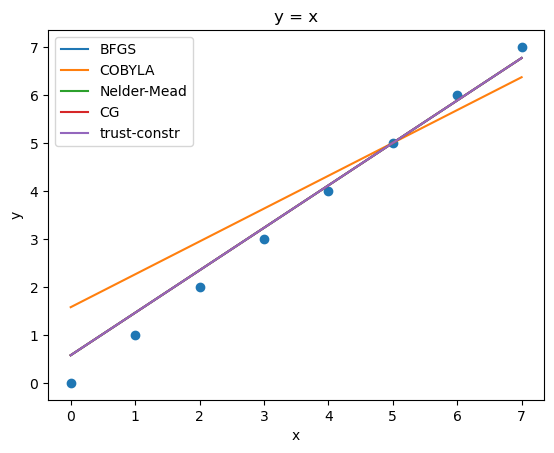

In [5]:
#first set up the data sets x and y

x = np.arange(0,8,1)
y = x   # + [random.uniform(-1,1) for p in range(8)]    # can add noise here
N = len(x)
nqubits = math.ceil(np.log2(N))
       
ynorm = np.linalg.norm(y)      # normalise the y data set
y = y/ynorm

x0 = [0.5,0.5]                 # initial guess for a and b

#now use different classical optimisers to see which one works best

out = minimize(calculate_cost_function, x0=x0, method="BFGS", options={'maxiter':200}, tol=1e-6)
out1 = minimize(calculate_cost_function, x0=x0, method="COBYLA", options={'maxiter':200}, tol=1e-6)
out2 = minimize(calculate_cost_function, x0=x0, method="Nelder-Mead", options={'maxiter':200}, tol=1e-6)
out3 = minimize(calculate_cost_function, x0=x0, method="CG", options={'maxiter':200}, tol=1e-6)
out4 = minimize(calculate_cost_function, x0=x0, method="trust-constr", options={'maxiter':200}, tol=1e-6)

out_a1 = out1['x'][0]
out_b1 = out1['x'][1]

out_a = out['x'][0]
out_b = out['x'][1]

out_a2 = out2['x'][0]
out_b2 = out2['x'][1]

out_a3 = out3['x'][0]
out_b3 = out3['x'][1]

out_a4 = out4['x'][0]
out_b4 = out4['x'][1]

plt.scatter(x,y*ynorm)
xfit = np.linspace(min(x), max(x), 100)
plt.plot(xfit, out_a*xfit+out_b, label='BFGS')
plt.plot(xfit, out_a1*xfit+out_b1, label='COBYLA')
plt.plot(xfit, out_a2*xfit+out_b2, label='Nelder-Mead')
plt.plot(xfit, out_a3*xfit+out_b3, label='CG')
plt.plot(xfit, out_a4*xfit+out_b4, label='trust-constr')
plt.legend()
plt.title("y = x")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Veamos a nivel práctico como se realiza, la única diferencia seria en la definición en la función de coste,
se calculare la probabilidad a golpe muchas ejecuciones

In [6]:
#Circuito cuántico que calcula el producto vecotorial entre dos vectores

def inner_prod(vec1, vec2):
    #first check lengths are equal
    if len(vec1) != len(vec2):
        raise ValueError('Lengths of states are not equal')
        
    circ = QuantumCircuit(nqubits+1,1)
    vec = np.concatenate((vec1,vec2))/np.sqrt(2)
    
    circ.initialize(vec, range(nqubits+1))
    circ.h(nqubits)
    circ.measure(nqubits,0)

    backend = Aer.get_backend('qasm_simulator')
    job = execute(circ, backend, shots=20000) ## Muchas ejecuciones

    result = job.result()
    outputstate = result.get_counts(circ)

    if ('0' in outputstate.keys()):
        m_sum = float(outputstate["0"])/20000
    else:
        m_sum = 0
     
    return 2*m_sum-1

x = np.arange(0,8,1)
y = x

N = len(x)
nqubits = math.ceil(np.log2(N))
xnorm = np.linalg.norm(x)
ynorm = np.linalg.norm(y)
x = x/xnorm
y = y/ynorm

print("x: ", x)
print()
print("y: ", y)
print()
print("The inner product of x and y equals: ", inner_prod(x,y))

x:  [0.         0.08451543 0.16903085 0.25354628 0.3380617  0.42257713
 0.50709255 0.59160798]

y:  [0.         0.08451543 0.16903085 0.25354628 0.3380617  0.42257713
 0.50709255 0.59160798]

The inner product of x and y equals:  1.0


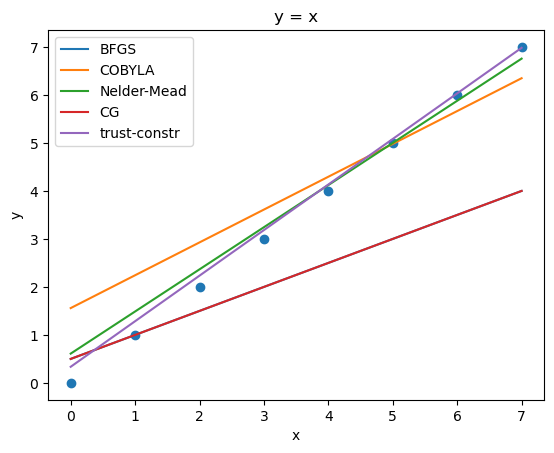

In [7]:
#first set up the data sets x and y

x = np.arange(0,8,1)
y = x   # + [random.uniform(-1,1) for p in range(8)]  # can add noise here
N = len(x)
nqubits = math.ceil(np.log2(N))

ynorm = np.linalg.norm(y)    # normalise y data set
y = y/ynorm

x0 = [0.5,0.5]       # initial guess for a and b

#now use different classical optimisers to see which one works best

out = minimize(calculate_cost_function, x0=x0, method="BFGS", options={'maxiter':200}, tol=1e-6)
out1 = minimize(calculate_cost_function, x0=x0, method="COBYLA", options={'maxiter':200}, tol=1e-6)
out2 = minimize(calculate_cost_function, x0=x0, method="Nelder-Mead", options={'maxiter':200}, tol=1e-6)
out3 = minimize(calculate_cost_function, x0=x0, method="CG", options={'maxiter':200}, tol=1e-6)
out4 = minimize(calculate_cost_function, x0=x0, method="trust-constr", options={'maxiter':200}, tol=1e-6)

out_a1 = out1['x'][0]
out_b1 = out1['x'][1]

out_a = out['x'][0]
out_b = out['x'][1]

out_a2 = out2['x'][0]
out_b2 = out2['x'][1]

out_a3 = out3['x'][0]
out_b3 = out3['x'][1]

out_a4 = out4['x'][0]
out_b4 = out4['x'][1]

plt.scatter(x,y*ynorm)
xfit = np.linspace(min(x), max(x), 100)
plt.plot(xfit, out_a*xfit+out_b, label='BFGS')
plt.plot(xfit, out_a1*xfit+out_b1, label='COBYLA')
plt.plot(xfit, out_a2*xfit+out_b2, label='Nelder-Mead')
plt.plot(xfit, out_a3*xfit+out_b3, label='CG')
plt.plot(xfit, out_a4*xfit+out_b4, label='trust-constr')
plt.legend()
plt.title("y = x")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [8]:
# New cost function calculation, allowing for higher order polynomials
# Implements the entire cost function by feeding the ansatz to the quantum circuit which computes inner products
def calculate_cost_function_n(parameters):
    
    ansatz = parameters[0]                   # compute ansatz

    for i in range(1,len(parameters)):

        ansatz += parameters[i] * x**i
        
    ansatzNorm = np.linalg.norm(ansatz)      # normalise ansatz
    ansatz = ansatz/ansatzNorm
    y_ansatz = ansatzNorm/ynorm * inner_prod(y,ansatz)     # use quantum circuit to test ansatz
                                                           # note the normalisation factors

    return (1-y_ansatz)**2

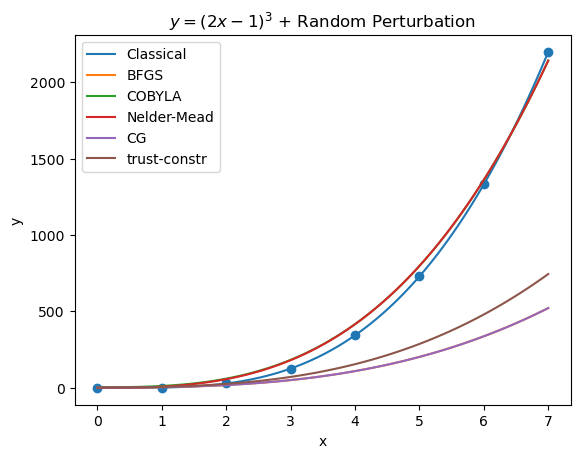

In [9]:
#first set up the data sets x and y

x = np.arange(0,8,1)
y = (2*x-1)**3 + [random.uniform(-1,1) for p in range(8)]
N = len(x)
nqubits = math.ceil(np.log2(N))
       
ynorm = np.linalg.norm(y)       #normalise y data set
y = y/ynorm

order = 3

x0 = [random.uniform(0,2) for p in range(order+1)]    #random initial guess for a and b

#now use different classical optimisers to see which one works best

out = minimize(calculate_cost_function_n, x0=x0, method="BFGS", options={'maxiter':200}, tol=1e-6)
out1 = minimize(calculate_cost_function_n, x0=x0, method="COBYLA", options={'maxiter':200}, tol=1e-6)
out2 = minimize(calculate_cost_function_n, x0=x0, method="Nelder-Mead", options={'maxiter':200}, tol=1e-6)
out3 = minimize(calculate_cost_function_n, x0=x0, method="CG", options={'maxiter':200}, tol=1e-6)
out4 = minimize(calculate_cost_function_n, x0=x0, method="trust-constr", options={'maxiter':200}, tol=1e-6)

class_fit = np.polyfit(x,y*ynorm,order)
class_fit = class_fit[::-1]

xfit = np.linspace(min(x), max(x), 100)

def return_fits(xfit):
    c_fit = np.zeros(100)
    q_fit = np.zeros(100)
    q_fit1 = np.zeros(100)
    q_fit2 = np.zeros(100)
    q_fit3 = np.zeros(100)
    q_fit4 = np.zeros(100)
    for i in range(order+1):
        c_fit += xfit**i*class_fit[i]
        q_fit += xfit**i*out['x'][i]
        q_fit1 += xfit**i*out1['x'][i]
        q_fit2 += xfit**i*out2['x'][i]
        q_fit3 += xfit**i*out3['x'][i]
        q_fit4 += xfit**i*out4['x'][i]
        

    return c_fit, q_fit, q_fit1, q_fit2, q_fit3, q_fit4

c_fit, q_fit, q_fit1, q_fit2, q_fit3, q_fit4 = return_fits(xfit)

plt.scatter(x,y*ynorm)
xfit = np.linspace(min(x), max(x), 100)
plt.plot(xfit, c_fit, label='Classical')
plt.plot(xfit, q_fit, label='BFGS')
plt.plot(xfit, q_fit1, label='COBYLA')
plt.plot(xfit, q_fit2, label='Nelder-Mead')
plt.plot(xfit, q_fit3, label='CG')
plt.plot(xfit, q_fit4, label='trust-constr')
plt.legend()
plt.title("$y = (2x-1)^3$ + Random Perturbation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()